## `STEP 1: PRE-PROCESSING`

📌 Importing necessary libraries

In [1]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import shap
import random
from protree.explainers import G_KM
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import numpy as np
shap.initjs()

c:\Users\joasi\Documents\PP\SEM_5\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


📌 Read our data

In [2]:
df_file = pd.read_csv('weather_classification_data.csv')
df_file.head() 

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy


📌 Getting 1000 first rows

In [3]:
num_rows = df_file.shape[0]
print(f"Number of rows: {num_rows}")

Number of rows: 13200


In [4]:
# bc of many rows we take only first 1000 rows
df = df_file.iloc[:1000]


📌 Check for Null Values in the Data

In [5]:
df.isnull().sum()


Temperature             0
Humidity                0
Wind Speed              0
Precipitation (%)       0
Cloud Cover             0
Atmospheric Pressure    0
UV Index                0
Season                  0
Visibility (km)         0
Location                0
Weather Type            0
dtype: int64

📌 Check basic information about numeric columns in the Data

In [6]:
df.describe()

,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km)
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,19.220000,69.087000,9.623000,54.542000,1006.136820,3.887000,5.325500
std,16.738751,20.817993,6.902066,32.021049,36.537902,3.754508,3.155116
min,-24.000000,20.000000,0.000000,0.000000,805.400000,0.000000,0.000000
25%,8.000000,57.000000,5.000000,20.000000,994.830000,1.000000,3.000000
50%,21.000000,70.000000,8.500000,59.000000,1008.155000,3.000000,5.000000
75%,31.000000,85.000000,13.500000,83.000000,1016.985000,6.000000,7.500000
max,91.000000,109.000000,47.000000,109.000000,1196.030000,14.000000,19.000000


📌 Make Discretization in the Data

In [7]:
k_bins = 3
labels = ["low_temperature", "medium_temperature", "high_temperature"]
df['Temperature'] = pd.cut(df['Temperature'], bins=k_bins, labels=labels)

df.head()

C:\Users\joasi\AppData\Local\Temp\ipykernel_20956\4058179103.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Temperature'] = pd.cut(df['Temperature'], bins=k_bins, labels=labels)


,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,low_temperature,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,medium_temperature,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,medium_temperature,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,medium_temperature,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,medium_temperature,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy


📌 Make Encoding in the Data

In [8]:
# Getting our Data and Target Value separately
df_X = df.drop(['Weather Type'], axis = 1)
df_y = df[['Weather Type']]

df_X

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location
0,low_temperature,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland
1,medium_temperature,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland
2,medium_temperature,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain
3,medium_temperature,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal
4,medium_temperature,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain
...,...,...,...,...,...,...,...,...,...,...
995,low_temperature,69,10.0,64.0,overcast,983.29,0,Winter,4.5,mountain
996,medium_temperature,55,6.5,19.0,partly cloudy,1018.38,5,Autumn,7.5,inland
997,medium_temperature,91,8.5,86.0,clear,1029.24,6,Autumn,5.5,mountain
998,low_temperature,89,9.5,93.0,partly cloudy,982.68,0,Winter,3.5,mountain


In [9]:
# Making encoding on Data
df_X_encoded = pd.get_dummies(df_X)

# Changing bool values to int
bool_columns = df_X_encoded.select_dtypes(include=['bool']).columns  
df_X_encoded[bool_columns] = df_X_encoded[bool_columns].astype(int)  

df_X_encoded.head()

,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km),Temperature_low_temperature,Temperature_medium_temperature,Temperature_high_temperature,Cloud Cover_clear,Cloud Cover_cloudy,Cloud Cover_overcast,Cloud Cover_partly cloudy,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,Location_coastal,Location_inland,Location_mountain
0,73,9.5,82.0,1010.82,2,3.5,1,0,0,0,0,0,1,0,0,0,1,0,1,0
1,96,8.5,71.0,1011.43,7,10.0,0,1,0,0,0,0,1,0,1,0,0,0,1,0
2,64,7.0,16.0,1018.72,5,5.5,0,1,0,1,0,0,0,0,1,0,0,0,0,1
3,83,1.5,82.0,1026.25,7,1.0,0,1,0,1,0,0,0,0,1,0,0,1,0,0
4,74,17.0,66.0,990.67,1,2.5,0,1,0,0,0,1,0,0,0,0,1,0,0,1


In [10]:
# Making encoding on Target Value
label_encoder = LabelEncoder()
df_y.loc[:, 'Weather Type encoded'] = label_encoder.fit_transform(df_y['Weather Type'])

y = df_y['Weather Type encoded']
df_y.head()

C:\Users\joasi\AppData\Local\Temp\ipykernel_20956\3951848184.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y.loc[:, 'Weather Type encoded'] = label_encoder.fit_transform(df_y['Weather Type'])


,Weather Type,Weather Type encoded
0,Rainy,1
1,Cloudy,0
2,Sunny,3
3,Sunny,3
4,Rainy,1


## `STEP 2: CREATING A MODEL`


📌 Splitting the dataset into training (70%) and testing (30%) sets and build two models: an XGBoost Classifier and a Random Forest Classifier.

In [11]:
# XGBoost Classifier
X_train, X_test, y_train, y_test = train_test_split(df_X_encoded, y, test_size=0.3, random_state=42)

model_XGBoost = XGBClassifier(random_state=42).fit(X_train, y_train)

y_pred = model_XGBoost.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'XGBoost Accuracy: {accuracy:.4f}')

XGBoost Accuracy: 0.8933


In [12]:
#Random Forest Classifier
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df_X_encoded, y, test_size=0.3, random_state=42)

model_RF_Classifier = RandomForestClassifier(random_state=42).fit(X_train_2, y_train_2)

y_pred = model_RF_Classifier.predict(X_test_2)
accuracy = accuracy_score(y_test_2, y_pred)
print(f'Random Forest Accuracy: {accuracy:.4f}')

Random Forest Accuracy: 0.8833


## STEP 2: `FEATUE IMPORTANCE` - FIRST EXPLANATORY METHOD

In [13]:
# XGBoost Classifier with SHAP

explainer = shap.Explainer(model_XGBoost)
shap_values = explainer(X_test)

probs = model_XGBoost.predict_proba(X_test)
class_labels = label_encoder.classes_
print(class_labels)

['Cloudy' 'Rainy' 'Snowy' 'Sunny']


In [14]:
# function that help getting waterplot 
def getWaterfallForPredictedClass(index_instance, probs, class_labels):
    
    max_index = np.argmax(probs[index_instance])
    shap.plots.waterfall(shap_values[0, :, max_index])
    predicted_class = class_labels[max_index]

    print(f"For the instance above the model predicted class: {predicted_class}")

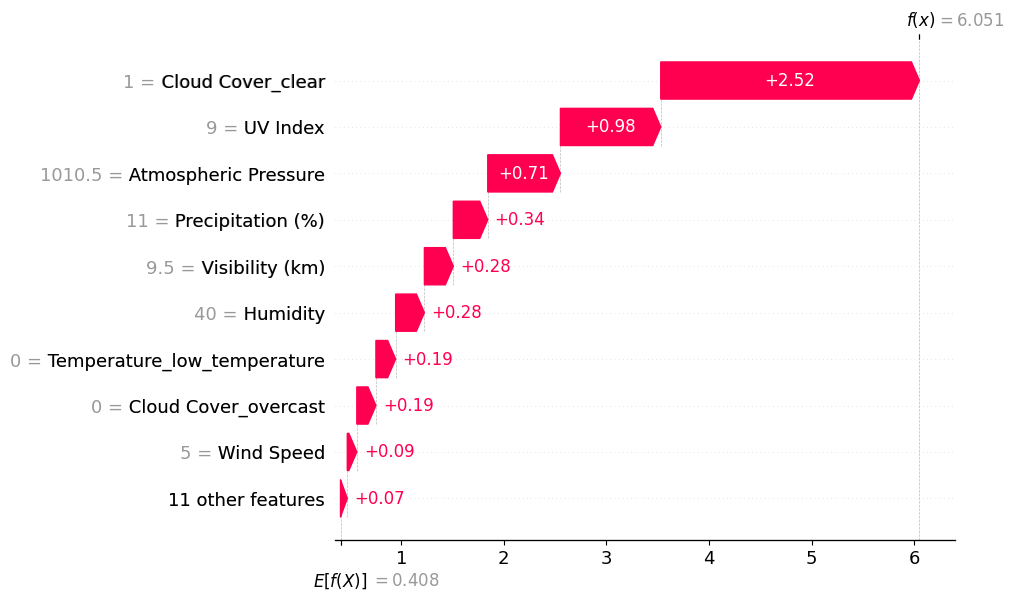

For the instance above the model predicted class: Sunny


In [15]:
getWaterfallForPredictedClass(0, probs, class_labels)

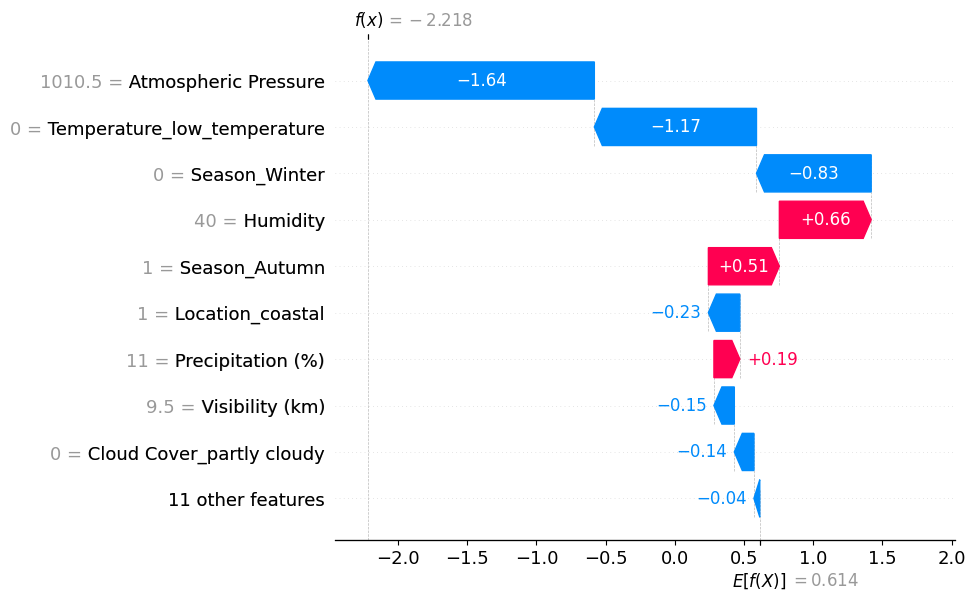

For the instance above the model predicted class: Snowy


In [16]:
getWaterfallForPredictedClass(100, probs, class_labels)

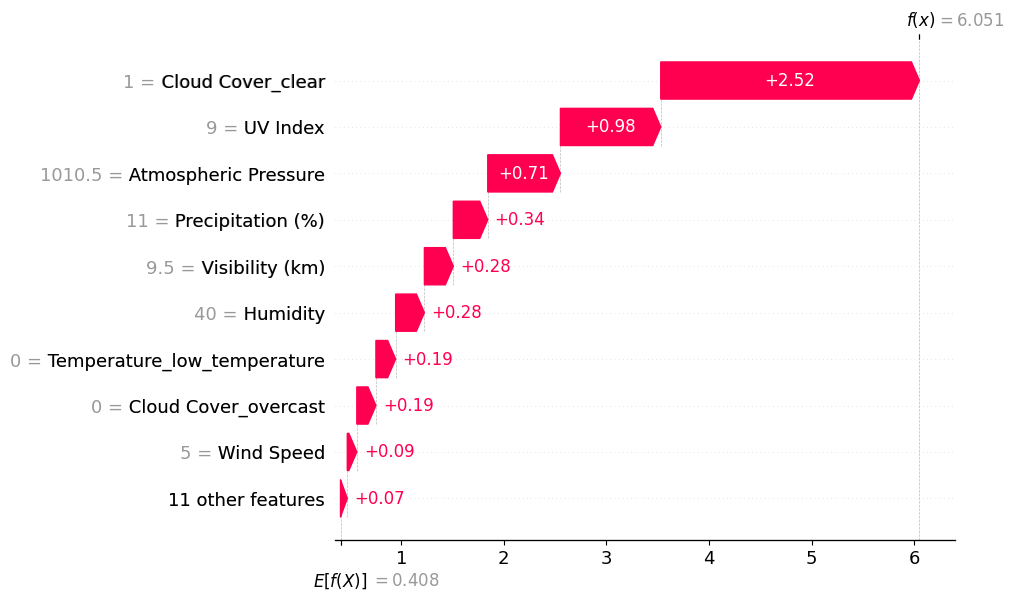

For the instance above the model predicted class: Sunny


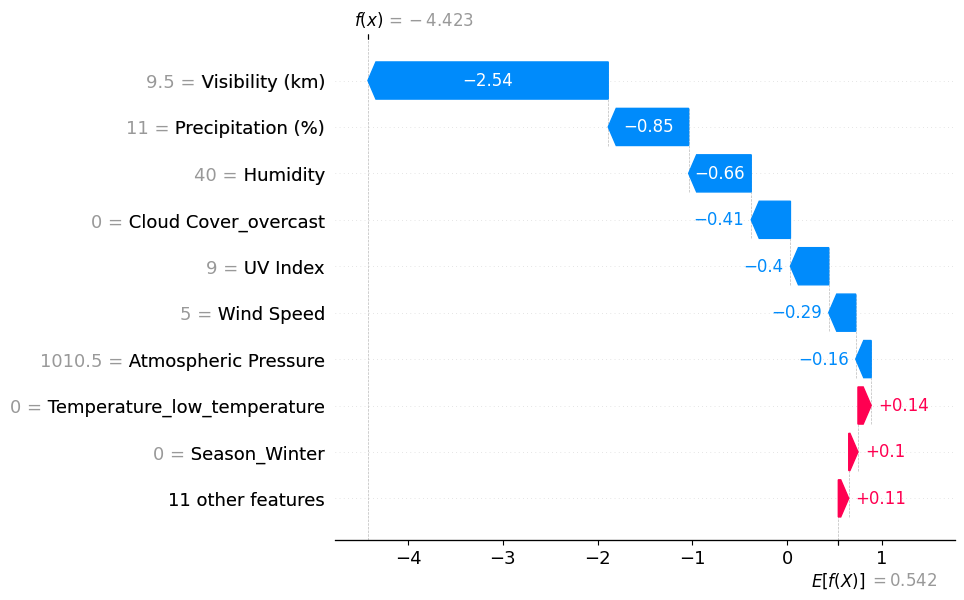

For the instance above the model predicted class: Rainy


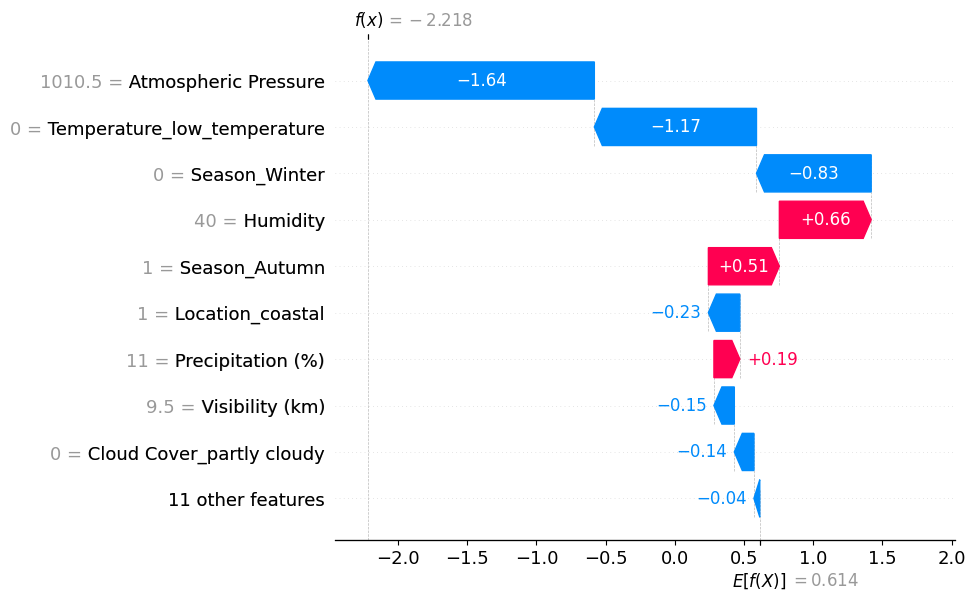

For the instance above the model predicted class: Snowy


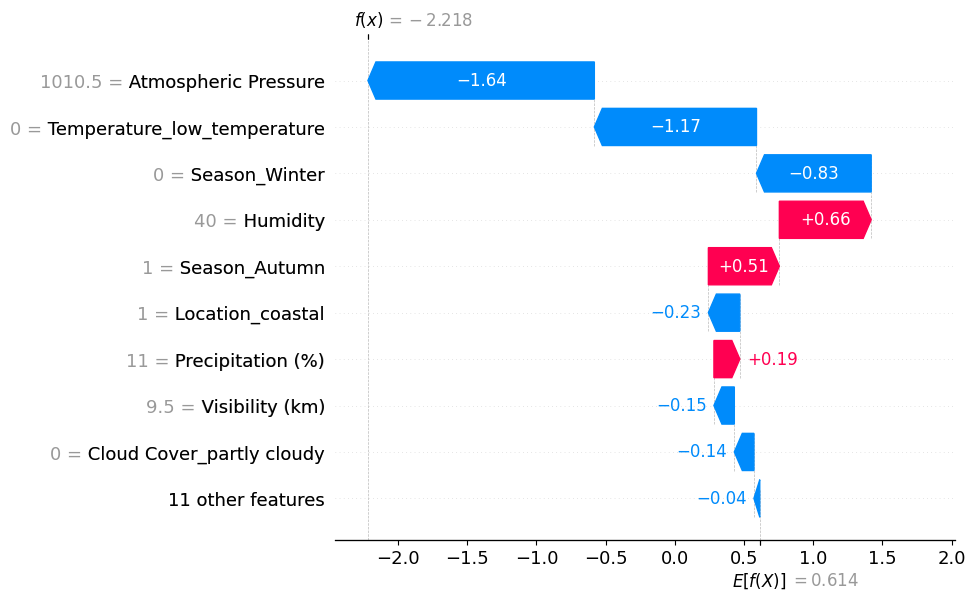

For the instance above the model predicted class: Snowy


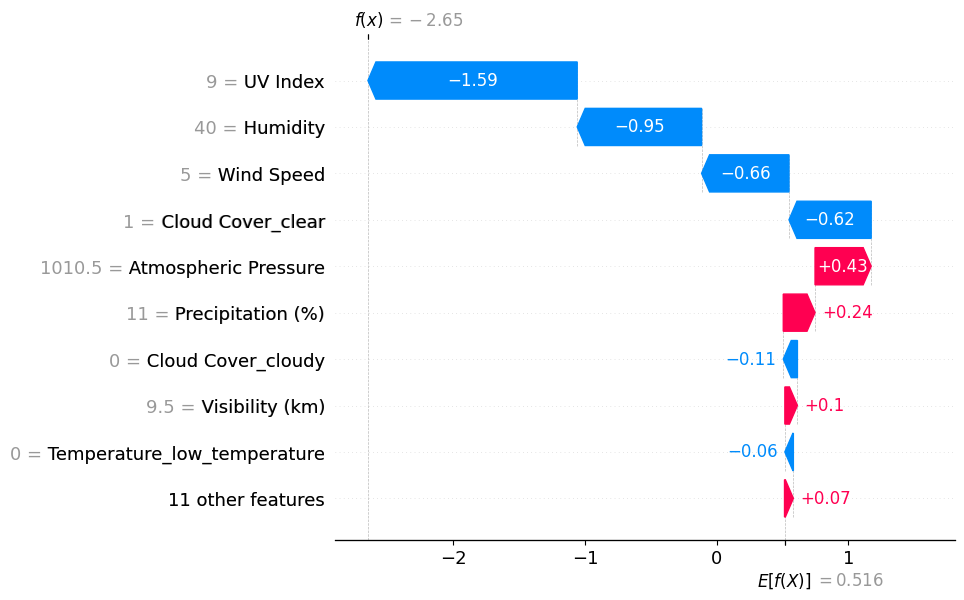

For the instance above the model predicted class: Cloudy


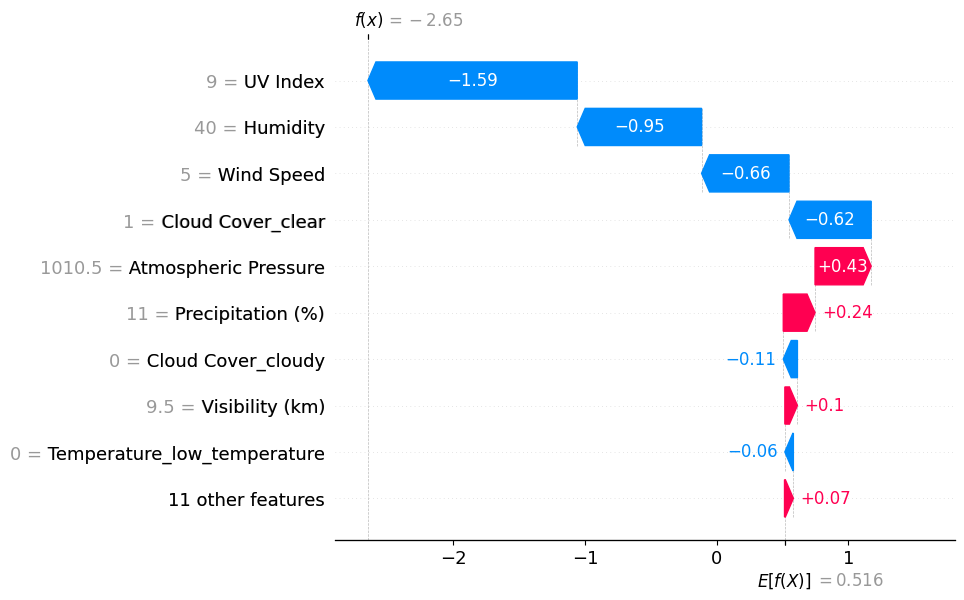

For the instance above the model predicted class: Cloudy


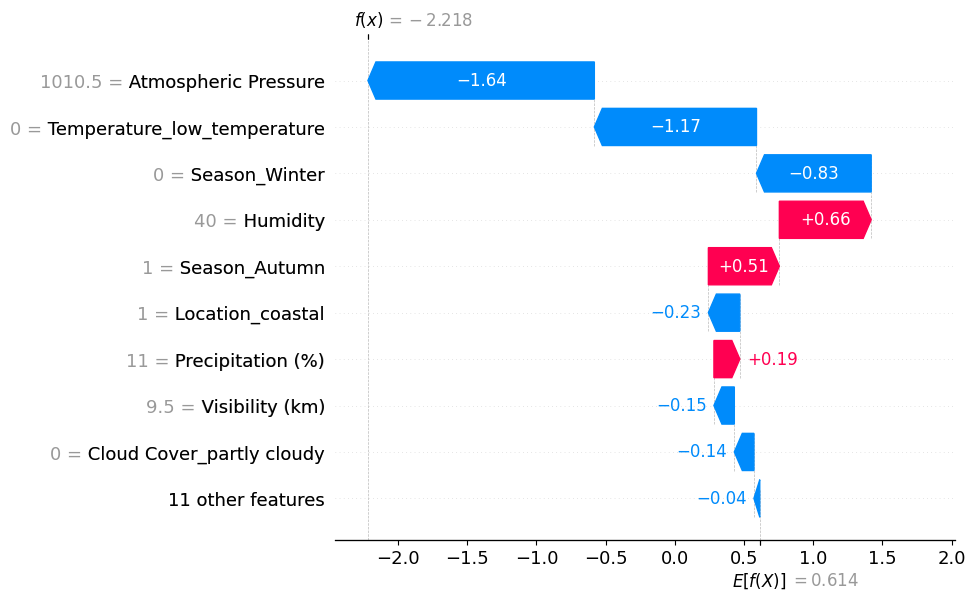

For the instance above the model predicted class: Snowy


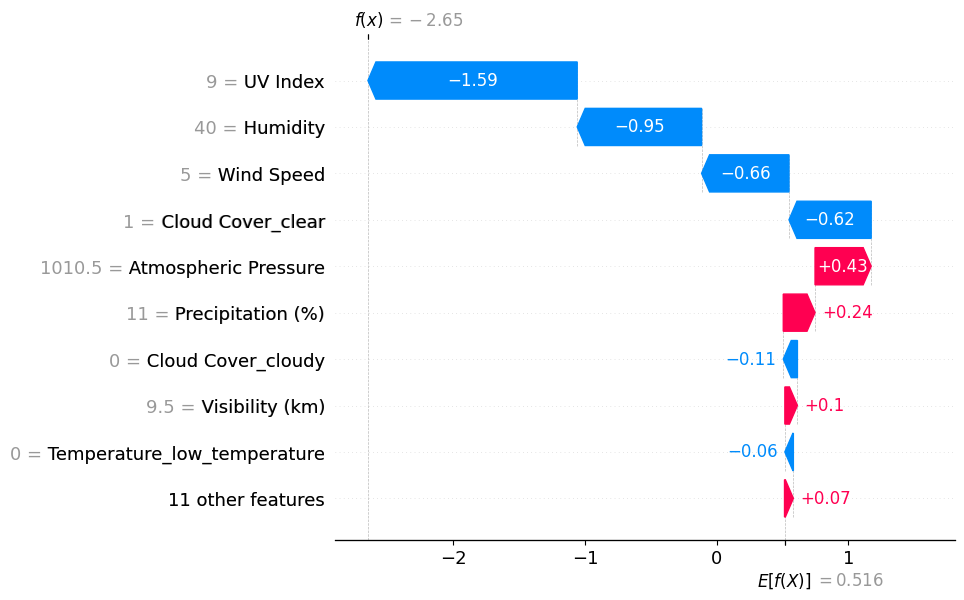

For the instance above the model predicted class: Cloudy


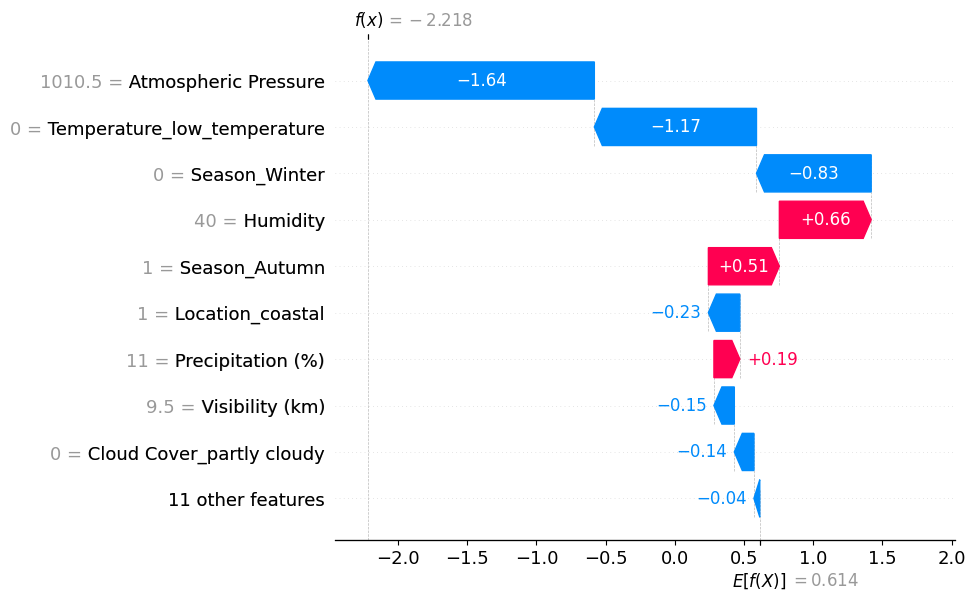

For the instance above the model predicted class: Snowy


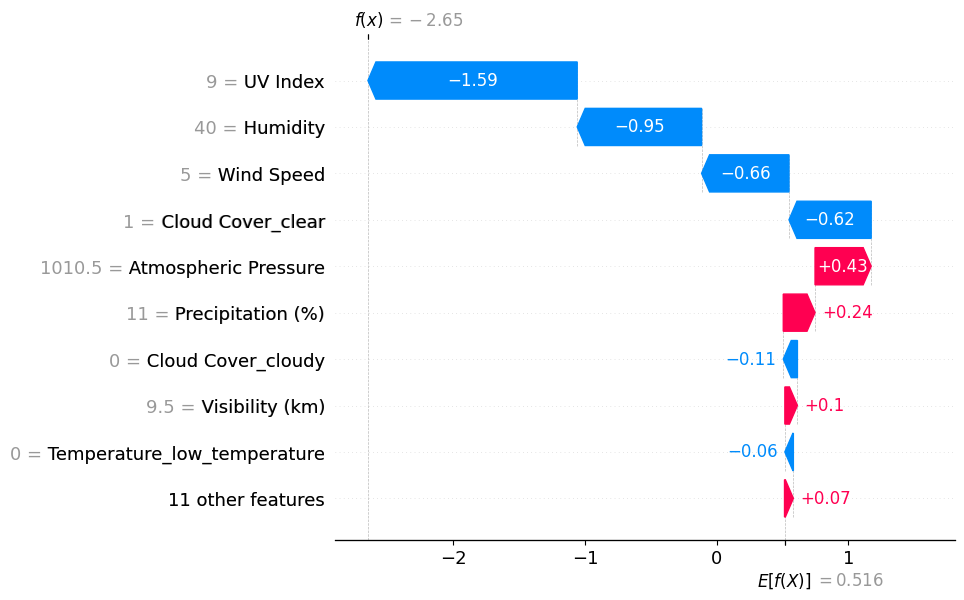

For the instance above the model predicted class: Cloudy


In [17]:
for i in range(10):
    getWaterfallForPredictedClass(i, probs, class_labels)

## STEP 3: `PROTOTYPES` - SECOND EXPLANATORY METHOD


In [18]:
explainer = G_KM(model = model_RF_Classifier, n_prototypes = 5)
prototypes = explainer.select_prototypes(X_train_2)
print(prototypes)

{0:      Humidity  Wind Speed  Precipitation (%)  Atmospheric Pressure  UV Index  \
905        71        21.0               86.0               1013.77        12   
320        82        14.5               96.0               1014.44         8   
556        99        13.5               80.0               1002.93        14   
860        73        10.0               84.0               1000.06        14   
541        79         0.0               39.0               1015.32         4   

     Visibility (km)  Temperature_low_temperature  \
905              6.5                            0   
320              7.0                            1   
556              9.0                            0   
860              8.0                            1   
541              6.0                            0   

     Temperature_medium_temperature  Temperature_high_temperature  \
905                               1                             0   
320                               0                       

In [19]:
# List for storing rows
from copy import deepcopy

prototype_list = []
num_of_rows = 0

for key, prototype in prototypes.items():
    print(f"Prototype {key}:")
    print(prototype.head())

    num_of_rows += len(prototype)
    # Adding a column, so we know which class it is
    prototype_copy = deepcopy(prototype)
    prototype_copy['Class'] = key

    # Appending to the list
    # prototype_list.append(prototype)
    prototype_list.append(prototype_copy)

prototypes_df = pd.concat(prototype_list, ignore_index=True)
prototypes_df.head(num_of_rows)

Prototype 0:
     Humidity  Wind Speed  Precipitation (%)  Atmospheric Pressure  UV Index  \
905        71        21.0               86.0               1013.77        12   
320        82        14.5               96.0               1014.44         8   
556        99        13.5               80.0               1002.93        14   
860        73        10.0               84.0               1000.06        14   
541        79         0.0               39.0               1015.32         4   

     Visibility (km)  Temperature_low_temperature  \
905              6.5                            0   
320              7.0                            1   
556              9.0                            0   
860              8.0                            1   
541              6.0                            0   

     Temperature_medium_temperature  Temperature_high_temperature  \
905                               1                             0   
320                               0              

,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km),Temperature_low_temperature,Temperature_medium_temperature,Temperature_high_temperature,Cloud Cover_clear,...,Cloud Cover_overcast,Cloud Cover_partly cloudy,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,Location_coastal,Location_inland,Location_mountain,Class
0,71,21.0,86.0,1013.77,12,6.5,0,1,0,0,...,0,1,0,0,0,1,0,1,0,0
1,82,14.5,96.0,1014.44,8,7.0,1,0,0,0,...,1,0,1,0,0,0,0,1,0,0
2,99,13.5,80.0,1002.93,14,9.0,0,1,0,0,...,1,0,0,1,0,0,1,0,0,0
3,73,10.0,84.0,1000.06,14,8.0,1,0,0,0,...,1,0,0,1,0,0,0,0,1,0
4,79,0.0,39.0,1015.32,4,6.0,0,1,0,0,...,0,1,0,0,1,0,1,0,0,0
5,97,20.5,81.0,1005.35,12,5.5,0,1,0,0,...,1,0,0,1,0,0,1,0,0,1
6,72,4.5,72.0,1193.57,11,13.0,1,0,0,0,...,1,0,0,0,1,0,0,0,1,1
7,62,5.5,79.0,1012.12,4,5.5,1,0,0,0,...,0,1,0,0,0,1,1,0,0,1
8,76,17.5,106.0,1019.09,2,5.5,1,0,0,0,...,1,0,1,0,0,0,1,0,0,1
9,48,5.0,74.0,1022.96,8,5.5,1,0,0,0,...,0,1,0,1,0,0,1,0,0,1


In [20]:
prototypes_df.columns

Index(['Humidity', 'Wind Speed', 'Precipitation (%)', 'Atmospheric Pressure',
       'UV Index', 'Visibility (km)', 'Temperature_low_temperature',
       'Temperature_medium_temperature', 'Temperature_high_temperature',
       'Cloud Cover_clear', 'Cloud Cover_cloudy', 'Cloud Cover_overcast',
       'Cloud Cover_partly cloudy', 'Season_Autumn', 'Season_Spring',
       'Season_Summer', 'Season_Winter', 'Location_coastal', 'Location_inland',
       'Location_mountain', 'Class'],
      dtype='object')

In [21]:
# DECODING

# list of categories to delete
categories_1 = ['Temperature_low_temperature', 'Temperature_medium_temperature','Temperature_high_temperature']
categories_2 = ['Cloud Cover_clear', 'Cloud Cover_cloudy', 'Cloud Cover_overcast', 'Cloud Cover_partly cloudy']
categories_3 = ['Season_Autumn', 'Season_Spring', 'Season_Summer', 'Season_Winter']
categories_4 = ['Location_coastal', 'Location_inland', 'Location_mountain']

def remove_words(main_word, words_to_remove):
    for word in words_to_remove:
        main_word = main_word.replace(word, '')
    return main_word


def decode_one_hot(df, category_columns):
    decoded_labels = []
    for _, row in df[category_columns].iterrows():
        index = row.idxmax()  # Get the column name with the max value (1)
        decoded_labels.append(remove_words(index, ['Temperature_','Cloud Cover_','Season_', 'Location_']))  
    return decoded_labels

# Decoding the specified columns
prototypes_df['Temperature'] = decode_one_hot(prototypes_df, categories_1)
prototypes_df['Cloud Cover_'] = decode_one_hot(prototypes_df, categories_2)
prototypes_df['Season_'] = decode_one_hot(prototypes_df, categories_3)
prototypes_df['Location_'] = decode_one_hot(prototypes_df, categories_4)


# Droping rest columns
prototypes_df =prototypes_df.drop(columns=categories_1+categories_2+categories_3+categories_4)

prototypes_df.head()

,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km),Class,Temperature,Cloud Cover_,Season_,Location_
0,71,21.0,86.0,1013.77,12,6.5,0,medium_temperature,partly cloudy,Winter,inland
1,82,14.5,96.0,1014.44,8,7.0,0,low_temperature,overcast,Autumn,inland
2,99,13.5,80.0,1002.93,14,9.0,0,medium_temperature,overcast,Spring,coastal
3,73,10.0,84.0,1000.06,14,8.0,0,low_temperature,overcast,Spring,mountain
4,79,0.0,39.0,1015.32,4,6.0,0,medium_temperature,partly cloudy,Summer,coastal


In [22]:
X_train_df = deepcopy(X_test_2) 

X_train_df['Temperature'] = decode_one_hot(X_train_df, categories_1)
X_train_df['Cloud Cover_'] = decode_one_hot(X_train_df, categories_2)
X_train_df['Season_'] = decode_one_hot(X_train_df, categories_3)
X_train_df['Location_'] = decode_one_hot(X_train_df, categories_4)

X_balanced_df = X_train_df.drop(columns=categories_1+categories_2+categories_3+categories_4)
X_balanced_df.head()

,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km),Temperature,Cloud Cover_,Season_,Location_
521,40,5.0,11.0,1010.50,9,9.5,medium_temperature,clear,Autumn,coastal
737,96,24.5,97.0,1010.21,5,2.0,medium_temperature,partly cloudy,Winter,mountain
740,76,11.0,86.0,984.05,1,2.5,low_temperature,overcast,Winter,mountain
660,65,7.5,78.0,999.97,0,4.5,low_temperature,overcast,Winter,inland
411,57,8.5,36.0,1011.70,4,8.0,low_temperature,partly cloudy,Summer,coastal


In [23]:
# ['Cloudy' 'Rainy' 'Snowy' 'Sunny']
x_0, y_0 = X_test_2.values[0].reshape(1, -1), y_test_2.values[0]  ## class Sunny
print(y_0)
max_similarity = 0  
best_prototype = None
for _, p in prototypes[y_0].iterrows():
    if (pair_similarity := explainer.pair_similarity(x_0, p)) > max_similarity:
        max_similarity = pair_similarity
        best_prototype = p

print("Max similarity: ", max_similarity)
print(best_prototype)

X = X_balanced_df.iloc[[0]].copy()
# X['Class'] = y_0
daily_rate_to_match = best_prototype['Humidity']
matching_index = prototypes_df[prototypes_df['Humidity'] == daily_rate_to_match].index[0]
prototypes_df_cleaned = prototypes_df.iloc[[matching_index]].drop(columns=['Class'])
combined_df = pd.concat([X, prototypes_df_cleaned], axis=0)
combined_df.index = ['INSTANCE', 'PROTOTYPE']
combined_df

3
Max similarity:  0.31
Humidity                           105.00
Wind Speed                           3.00
Precipitation (%)                   86.00
Atmospheric Pressure              1015.64
UV Index                             9.00
Visibility (km)                      7.50
Temperature_low_temperature          0.00
Temperature_medium_temperature       1.00
Temperature_high_temperature         0.00
Cloud Cover_clear                    1.00
Cloud Cover_cloudy                   0.00
Cloud Cover_overcast                 0.00
Cloud Cover_partly cloudy            0.00
Season_Autumn                        0.00
Season_Spring                        0.00
Season_Summer                        0.00
Season_Winter                        1.00
Location_coastal                     0.00
Location_inland                      0.00
Location_mountain                    1.00
Name: 927, dtype: float64


,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km),Temperature,Cloud Cover_,Season_,Location_
INSTANCE,40,5.0,11.0,1010.50,9,9.5,medium_temperature,clear,Autumn,coastal
PROTOTYPE,105,3.0,86.0,1015.64,9,7.5,medium_temperature,clear,Winter,mountain


In [24]:
x_0, y_0 = X_test_2.values[20].reshape(1, -1), y_test_2.values[20]  ## class Snowy
print(y_0)
max_similarity = 0  
best_prototype = None
for _, p in prototypes[y_0].iterrows():
    if (pair_similarity := explainer.pair_similarity(x_0, p)) > max_similarity:
        max_similarity = pair_similarity
        best_prototype = p

print("Max similarity: ", max_similarity)
print(best_prototype)

X = X_balanced_df.iloc[[20]].copy()
# X['Class'] = y_0
daily_rate_to_match = best_prototype['Humidity']
matching_index = prototypes_df[prototypes_df['Humidity'] == daily_rate_to_match].index[0]
prototypes_df_cleaned = prototypes_df.iloc[[matching_index]].drop(columns=['Class'])
combined_df = pd.concat([X, prototypes_df_cleaned], axis=0)
combined_df.index = ['INSTANCE', 'PROTOTYPE']
combined_df

2
Max similarity:  0.09
Humidity                          102.00
Wind Speed                         18.00
Precipitation (%)                  93.00
Atmospheric Pressure              984.22
UV Index                            9.00
Visibility (km)                     5.50
Temperature_low_temperature         1.00
Temperature_medium_temperature      0.00
Temperature_high_temperature        0.00
Cloud Cover_clear                   0.00
Cloud Cover_cloudy                  0.00
Cloud Cover_overcast                1.00
Cloud Cover_partly cloudy           0.00
Season_Autumn                       0.00
Season_Spring                       0.00
Season_Summer                       0.00
Season_Winter                       1.00
Location_coastal                    0.00
Location_inland                     1.00
Location_mountain                   0.00
Name: 572, dtype: float64


,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km),Temperature,Cloud Cover_,Season_,Location_
INSTANCE,89,19.5,54.0,994.67,0,3.5,low_temperature,overcast,Winter,mountain
PROTOTYPE,102,18.0,93.0,984.22,9,5.5,low_temperature,overcast,Winter,inland


In [25]:
# ['Cloudy' 'Rainy' 'Snowy' 'Sunny']
x_0, y_0 = X_test_2.values[4].reshape(1, -1), y_test_2.values[4]  ## class Cloudy
print(y_0)
max_similarity = 0  
best_prototype = None
for _, p in prototypes[y_0].iterrows():
    if (pair_similarity := explainer.pair_similarity(x_0, p)) > max_similarity:
        max_similarity = pair_similarity
        best_prototype = p

print("Max similarity: ", max_similarity)
print(best_prototype)

X = X_balanced_df.iloc[[4]].copy()
# X['Class'] = y_0
daily_rate_to_match = best_prototype['Humidity']
matching_index = prototypes_df[prototypes_df['Humidity'] == daily_rate_to_match].index[0]
prototypes_df_cleaned = prototypes_df.iloc[[matching_index]].drop(columns=['Class'])
combined_df = pd.concat([X, prototypes_df_cleaned], axis=0)
combined_df.index = ['INSTANCE', 'PROTOTYPE']
combined_df

0
Max similarity:  0.39
Humidity                            79.00
Wind Speed                           0.00
Precipitation (%)                   39.00
Atmospheric Pressure              1015.32
UV Index                             4.00
Visibility (km)                      6.00
Temperature_low_temperature          0.00
Temperature_medium_temperature       1.00
Temperature_high_temperature         0.00
Cloud Cover_clear                    0.00
Cloud Cover_cloudy                   0.00
Cloud Cover_overcast                 0.00
Cloud Cover_partly cloudy            1.00
Season_Autumn                        0.00
Season_Spring                        0.00
Season_Summer                        1.00
Season_Winter                        0.00
Location_coastal                     1.00
Location_inland                      0.00
Location_mountain                    0.00
Name: 541, dtype: float64


,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km),Temperature,Cloud Cover_,Season_,Location_
INSTANCE,57,8.5,36.0,1011.70,4,8.0,low_temperature,partly cloudy,Summer,coastal
PROTOTYPE,79,0.0,39.0,1015.32,4,6.0,medium_temperature,partly cloudy,Summer,coastal


In [26]:
# ['Cloudy' 'Rainy' 'Snowy' 'Sunny']
x_0, y_0 = X_test_2.values[10].reshape(1, -1), y_test_2.values[10]  ## class Rainy
print(y_0)
max_similarity = 0  
best_prototype = None
for _, p in prototypes[y_0].iterrows():
    if (pair_similarity := explainer.pair_similarity(x_0, p)) > max_similarity:
        max_similarity = pair_similarity
        best_prototype = p

print("Max similarity: ", max_similarity)
print(best_prototype)

X = X_balanced_df.iloc[[10]].copy()
# X['Class'] = y_0
daily_rate_to_match = best_prototype['Humidity']
matching_index = prototypes_df[prototypes_df['Humidity'] == daily_rate_to_match].index[0]
prototypes_df_cleaned = prototypes_df.iloc[[matching_index]].drop(columns=['Class'])
combined_df = pd.concat([X, prototypes_df_cleaned], axis=0)
combined_df.index = ['INSTANCE', 'PROTOTYPE']
combined_df

1
Max similarity:  0.04
Humidity                            97.00
Wind Speed                          20.50
Precipitation (%)                   81.00
Atmospheric Pressure              1005.35
UV Index                            12.00
Visibility (km)                      5.50
Temperature_low_temperature          0.00
Temperature_medium_temperature       1.00
Temperature_high_temperature         0.00
Cloud Cover_clear                    0.00
Cloud Cover_cloudy                   0.00
Cloud Cover_overcast                 1.00
Cloud Cover_partly cloudy            0.00
Season_Autumn                        0.00
Season_Spring                        1.00
Season_Summer                        0.00
Season_Winter                        0.00
Location_coastal                     1.00
Location_inland                      0.00
Location_mountain                    0.00
Name: 742, dtype: float64


,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km),Temperature,Cloud Cover_,Season_,Location_
INSTANCE,74,11.5,35.0,940.77,12,11.5,medium_temperature,cloudy,Spring,inland
PROTOTYPE,97,20.5,81.0,1005.35,12,5.5,medium_temperature,overcast,Spring,coastal
